# Preprocessing data for 3D ocean emulation

## Outstanding issues for generalization
- Ocean surface fields on different grid than the 3d outputs (CM4 specific) [Link]("ocean_surf_on_different_grid")
- 

In [1]:
## relying on all the dangling branches 🙈
# !pip install git+https://github.com/jbusecke/xgcm.git@conservative_transform_w_nans 

In [2]:
# !pip install -e /home/jovyan/PROJECTS/ocean_emulators/

In [20]:
from ocean_emulators.preprocessing import vertical_regrid, infer_vertical_cell_extent, spatially_regrid
import intake
import xarray as xr
import numpy as np
from xmip.preprocessing import combined_preprocessing
to_ddict_kwargs = dict(aggregate=False, preprocess=combined_preprocessing)

In [4]:
import os
os.environ['JUPYTER_IMAGE_SPEC']

'pangeo/pangeo-notebook:2024.06.02'

In [5]:
#From https://github.com/m2lines/ocean_emulators/issues/17
target_vertical_levels = np.array([   0,    5,   15,   30,   50,   80,  130,  200,  300,  450,  650,
        900, 1200, 1600, 2100, 2700, 3500, 4500, 5500, 6500])

In [6]:
# uncomment/comment lines to swap catalogs
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog.json" # Only stores that pass current tests
col = intake.open_esm_datastore(url)

In [7]:
# Quick workaround for https://github.com/leap-stc/cmip6-leap-feedstock/issues/146
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog_noqc.json" # Only stores that fail current tests
col_no_qc = intake.open_esm_datastore(url)

In [8]:
cat_atmos = col.search(source_id='GFDL-CM4', experiment_id='piControl', variable_id=['hfls', 'hfss'], table_id='Amon')
display(cat_atmos.df)
ddict_atmos = cat_atmos.to_dataset_dict(**to_ddict_kwargs)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,hfls,gr1,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
1,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Amon,hfss,gr1,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'


<a id="ocean_surf_on_different_grid"></a>

In [9]:

cat_ocean = col.search(source_id='GFDL-CM4', experiment_id='piControl', table_id='Omon', variable_id=['so', 'thetao', 'uo', 'vo'], grid_label='gn') #TODO: u and v are only on gn grid
cat_ocean_surf = col.search(source_id='GFDL-CM4', experiment_id='piControl', table_id='Omon', variable_id=['zos'], grid_label='gr')
display(cat_ocean.df)
display(cat_ocean_surf.df)
ddict_ocean = cat_ocean.to_dataset_dict(**to_ddict_kwargs)
ddict_ocean_surf = cat_ocean_surf.to_dataset_dict(**to_ddict_kwargs)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,uo,gn,none,r1i1p1f1,v20180701,gs://cmip6/cmip6-pgf-ingestion-test/zarr_store...
1,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,vo,gn,none,r1i1p1f1,v20180701,gs://cmip6/cmip6-pgf-ingestion-test/zarr_store...
2,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,so,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
3,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,thetao,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Omon,zos,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'


In [10]:
cat_grid_fixed = col_no_qc.search(source_id='GFDL-CM4', experiment_id='piControl', table_id=['Ofx', 'fx'], variable_id=['deptho', 'thkcello', 'areacello'], grid_label=['gr', 'gn'])
display(cat_grid_fixed.df)
ddict_grid_0 = cat_grid_fixed.to_dataset_dict(**to_ddict_kwargs)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,deptho,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
1,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,thkcello,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
2,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,areacello,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
3,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,deptho,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
4,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,thkcello,gn,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...
5,CMIP,NOAA-GFDL,GFDL-CM4,piControl,r1i1p1f1,Ofx,areacello,gr,none,r1i1p1f1,v20180701,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piCon...



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.sub_experiment_id.variant_label.version.zstore'


## Interpolate velocities onto tracer grid before any of the vertical regridding

TODO: check the implications for the wetmask here
FIXME: This needs more upstream work, since all the values for CM4 are on the center coordinate, pass through here for now

What I generally need here is a three step process

- Group datasets that should be combined with `combine_datasets`
- Find ref dataset, and detect lon/lat shifts for all other datasets
- parse datasets something like this: combine(ds_ref, [(ds_a, {'X':'left', 'Y':'center'}), (ds_b, {'X':'center', 'Y':'left'})])

Then i want to get a single datasets that has x, x_left, y, y_left coordinates and the data arrays from each one of them located appropriately within the output dataset
Also make sure that dataset can be immediately be metadata parsed for xgcm


In [11]:
# # This is a rewrite from xmip and needs to be upstreamed
# # from xmip.grids import combine_staggered_grid does not work anymore with modern xgcm version

# # What is new: 
# # - no more attempting to recreate metrics, if they are on the datasets, then parse them, otherwise dont do any calculations
# # - no way to overwrite the inferred shifts! The only way to manually change the position is to manipulate the metadata!

# # Questions: What about the depth? Should I parse the outer coordinates here?

# t = ddict_ocean['CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.thetao.gn.none.r1i1p1f1.v20180701.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/thetao/gn/v20180701/']
# u = ddict_ocean['CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.uo.gn.none.r1i1p1f1.v20180701.gs://cmip6/cmip6-pgf-ingestion-test/zarr_stores/9555660527_1/CMIP6.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.uo.gn.v20180701.zarr']
# v = ddict_ocean['CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.vo.gn.none.r1i1p1f1.v20180701.gs://cmip6/cmip6-pgf-ingestion-test/zarr_stores/9555660527_1/CMIP6.CMIP.NOAA-GFDL.GFDL-CM4.piControl.r1i1p1f1.Omon.vo.gn.v20180701.zarr']


# ds_base = t
# ds_other = [u,v]
# # just for testing (needs to be done with a lon/lat comparison in the full workflow)
# u_modified = u.copy()
# u_modified.x.attrs['c_grid_axis_shift'] = 1

# v_modified = v.copy()
# v_modified.y.attrs['c_grid_axis_shift'] = 1
# ds_other = [u_modified, v_modified]

# from xgcm.metadata_parsers import parse_metadata
# from typing import Dict, Tuple, Union, List

# def combine_staggered_grid(
#     ds_base, other_ds=None, 
#     default_shift:Union[Dict[str, Tuple[str, str]], Tuple[str, str]]=('center', 'left'),
#     exclude_axes:List[str]=['T'],
# ):
#     """
    
#     """
#     # figure out the shifts from base, if no other position than center is detected use some default?
#     # Only datasets with parseable metadata are accepted (any manual modification needs to be made before passing the inputs.
#     base_w_metadata = parse_metadata(ds_base)
#     other_w_metadata = [parse_metadata(ds) for ds in other_ds]
#     #TODO: I am not sure what this would do if it failed. Need to check with a different source_id
#     # TODO: Raise a useful error message that displays the error and the iid of the dataset

#     # collect unique axes:
#     all_metadata = [m for ds,m in [base_w_metadata]+other_w_metadata]
#     #TODO test that there will always be one value per axis?
    
#     axes_w_positions = {}
#     for md in all_metadata:
#         for axis, p_dict in md['coords'].items():
#             print(axis, p_dict)
#             for dim, pos in p_dict.items():
#                 if not axis in exclude_axes:
#                     if axis not in axes_w_positions.keys():
#                         axes_w_positions[axis] = []
#                     axes_w_positions[axis].extend(positions.keys())
    
#     # make sure positions are unique
#     axes_w_positions = {axis:list(set(positions)) for axis,positions in axes_w_positions.items()}

#     # Maybe expand default shifts to each axis
#     if not isinstance(default_shift, dict):
#         default_shift = {ax:default_shift for ax in axes_w_positions.keys()}

#     for ax, pos in axes_w_positions.items():
#         if len(pos) > 2:
#             raise ValueError(f"Cannot create a staggered xgcm grid with more than 2 positions per axis. Got {pos} for axis {ax}")
#         elif len(pos) == 1:
#             fill = default_shift[ax]
#             fill = [f for f in fill if f not in pos][0]
#             print(f"Only found a single axis position for axis {ax}. Filling in default shift value {fill}")
#             axes_w_positions[ax].append(fill)
    
#     # create the new dimensions according to the shift (retain the naming of ref dataset, and add suffix for all others)
    
#     ds_base, metadata_base = base_w_metadata
#     for ax, pos in axes_w_positions.items():
#         # determine which position is on the ref dataset
#         ref_pos = metadata_base['coords'][ax].keys()[0]
#         # determine the name for the new dimension and add it to the dataset
#         # TODO: Should this have coordinate values?
#         new_pos = [pos for pos in axes_w_positions[ax] if pos != ref_pos][0]
#         print(new_pos)
#         new_dimension = 1
#         print(new_dimension)
#     #then loop over "other" datasets and rename+add them so they sit on the appropriate positions of the output 
#     return axes_w_positions, metadata_base

# combine_staggered_grid(ds_base, ds_other)

In [12]:
from xmip.postprocessing import match_metrics, merge_variables
ddict_combined_on_tracer = merge_variables(ddict_ocean)

## Spatially regrid SSH for the depth inference (Shortcut, needs improvement)
This is needed for infering the cell depth, and certainly will influence accuracy (since this is much coarser res). 
For now I will use simple bilinear interpolation for this.

In [13]:
from xmip.postprocessing import combine_datasets, interpolate_grid_label
from typing import List

In [30]:
ddict_all_ocean = ddict_combined_on_tracer | ddict_ocean_surf
# ddict_all_ocean = {k:cmip_bounds_to_xesmf(ds) for k,ds in ddict_all_ocean.items()}
# ddict_all_ocean = interpolate_grid_label(ddict_all_ocean, target_grid_label='gn', method='conservative', )
# TODO: I need to factor out the _drop_duplicate_grid_label function (or make it optional)

## Running into issues with chunking (yay!). Lets try this brute force approach
ddict_all_ocean = {k:ds.chunk({'time':1}) for k,ds in ddict_all_ocean.items()}

In [31]:
# TODO: this should be an option for the xmip combine_grid_labels!
def _combine_grid_labels(ds_list:List[xr.Dataset]):
    # for now hardcode
    datasets = []
    matching_grid_label = [ds for ds in ds_list if ds.attrs['grid_label'] == 'gn']
    target_ds = matching_grid_label[0]
    for ds in ds_list:
        if ds.attrs['grid_label'] == 'gr':
            # Not effective if there are multiple 'other' datasets (not worth improving here, fix upstream instead)
            ds_regridded = spatially_regrid(ds, target_ds)
            # strip the attr from these
            ds_regridded.attrs = {}
            datasets.append(ds_regridded)
        else:
            datasets.append(ds)
    return xr.merge(datasets)
        
ddict_all_ocean_final = combine_datasets(ddict_all_ocean, _combine_grid_labels, match_attrs=['source_id', 'experiment_id', 'table_id', 'variant_label'])
ddict_all_ocean_final

{'GFDL-CM4.piControl.Omon.r1i1p1f1': <xarray.Dataset> Size: 5TB
 Dimensions:            (variant_label: 1, sub_experiment_id: 1, time: 6000,
                         lev: 35, y: 1080, x: 1440, bnds: 2, vertex: 4)
 Coordinates: (12/14)
     lat                (y, x) float32 6MB -79.81 -79.81 -79.8 ... 64.22 64.11
   * lev                (lev) float64 280B 2.5 10.0 20.0 ... 6e+03 6.5e+03
     lon                (y, x) float32 6MB 60.28 60.53 60.78 ... 60.0 60.0 60.0
   * time               (time) object 48kB 0151-01-16 12:00:00 ... 0650-12-16 ...
   * x                  (x) float64 12kB -299.7 -299.5 -299.2 ... 59.78 60.03
   * y                  (y) float64 9kB -80.39 -80.31 -80.23 ... 89.84 89.95
     ...                 ...
   * variant_label      (variant_label) object 8B 'r1i1p1f1'
   * sub_experiment_id  (sub_experiment_id) object 8B 'none'
     lon_verticies      (y, x, vertex) float32 25MB 60.16 60.15 ... 60.0 60.0
     lat_verticies      (y, x, vertex) float32 25MB -79.84 -79.78

## Combine and prep for vertical regridding

[This](https://github.com/jbusecke/xMIP/issues/355) came up when I tried to add 3d metrics to 2d fields

In [32]:
ddict_ocean_w_metrics = match_metrics(ddict_all_ocean_final, ddict_grid_0, ['deptho', 'thkcello', 'areacello'])

In [33]:
ddict_ocean_w_dz = {k:infer_vertical_cell_extent(ds) for k, ds in ddict_ocean_w_metrics.items()}

In [34]:
test = ddict_ocean_w_dz['GFDL-CM4.piControl.Omon.r1i1p1f1']

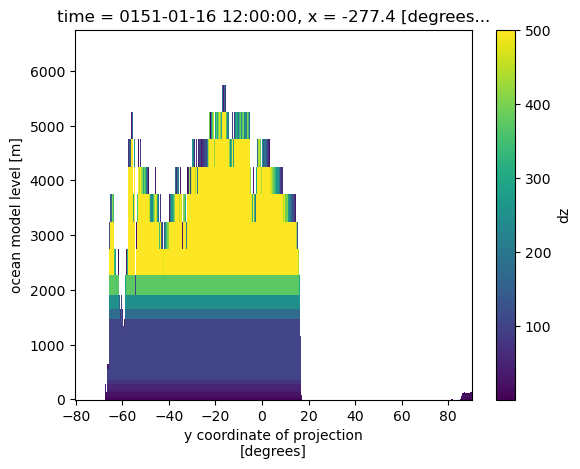

In [37]:
test.isel(time=0, x=90).dz.squeeze().plot()

Ah nice this actually seems to account for partial bottom cells!

In [38]:
ddict_vert_regridded = {k:vertical_regrid(ds, target_vertical_levels) for k, ds in ddict_ocean_w_dz.items()}

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/transform.py:255: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [41]:
test = ddict_ocean_w_dz['GFDL-CM4.piControl.Omon.r1i1p1f1'].isel(time=slice(0,2))
test_regridded = ddict_vert_regridded['GFDL-CM4.piControl.Omon.r1i1p1f1'].isel(time=slice(0,2)).astype(np.float32)

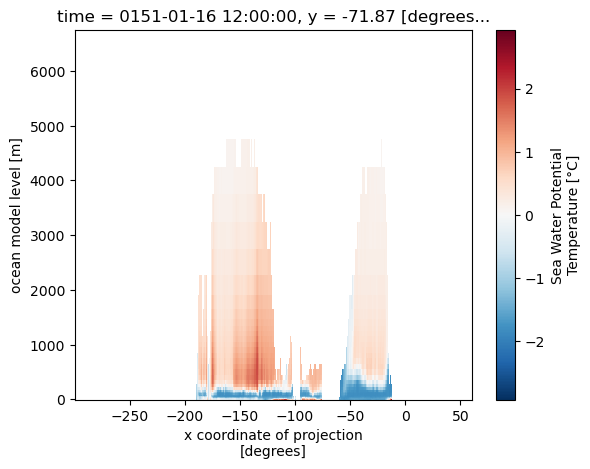

In [42]:
test.isel(time=0, y=90).thetao.squeeze().plot(x='x')

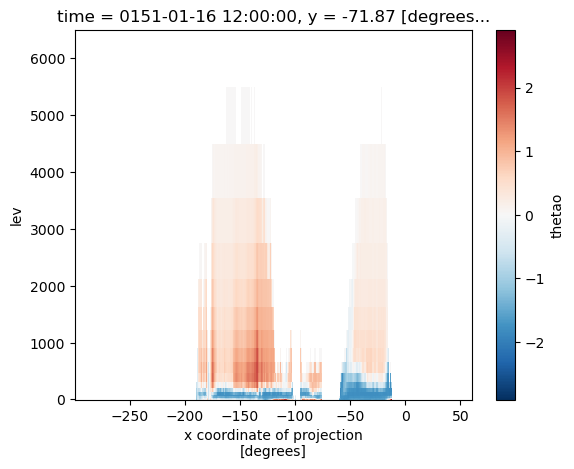

In [43]:
test_regridded.isel(time=0, y=90).thetao.squeeze().plot(x='x')

In [44]:
int_test = (test.astype(np.float64)*test.dz).sum('lev').load()
int_test_regridded = (test_regridded*test_regridded.dz).sum('lev').load()

In [45]:
transpose_order=set(int_test.sizes.keys())
int_test_regridded = int_test_regridded.transpose(*transpose_order)
int_test = int_test.transpose(*transpose_order)

In [46]:
# int_test_regridded

In [47]:
# int_test

In [48]:
xr.testing.assert_allclose(int_test, int_test_regridded, rtol=1e-4, atol=1e-4) # depends on dtype of the output TODO: for more cmip models ill have to deal with this! I probably just have to cast things a bit smarter. Visually these have very small differences.

AssertionError: Left and right Dataset objects are not close


Differing data variables:
L   thetao             (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
R   thetao             (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
L   so                 (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
R   so                 (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
L   vo                 (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
R   vo                 (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
L   zos                (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
R   zos                (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
L   uo                 (x, y, time, variant_label, sub_experiment_id) float64 25MB ...
R   uo                 (x, y, time, variant_label, sub_experiment_id) float64 25MB ...

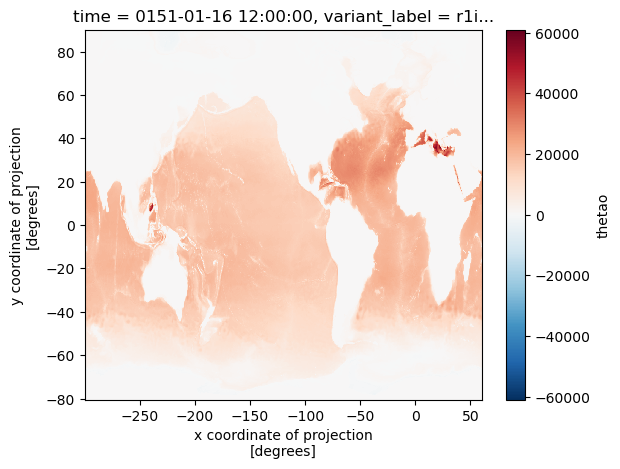

In [49]:
int_test.thetao.isel(time=0).plot(x='x')

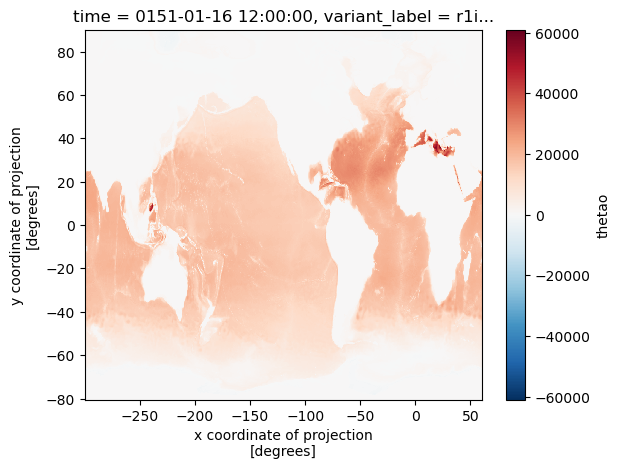

In [50]:
int_test_regridded.thetao.isel(time=0).plot(x='x')

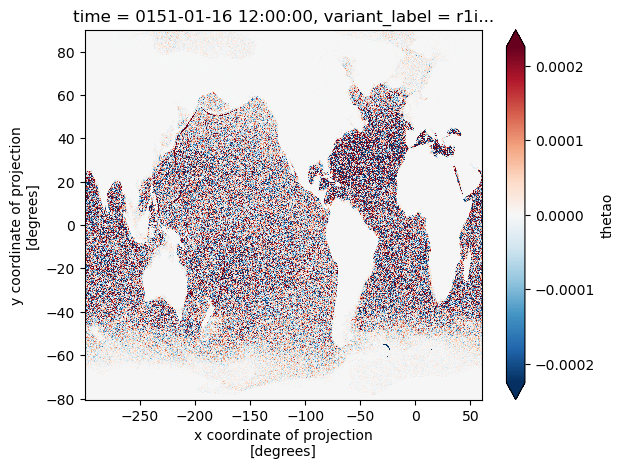

In [51]:
(int_test-int_test_regridded).thetao.isel(time=0).plot(robust=True, x='x')

## Uniform masking (Shortcut, needs revisiting)

In [ ]:
ds_test = 